In [ ]:
import pandas as pd
from transformers import pipeline
import pandas as pd
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
from sklearn.metrics import  r2_score,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import  ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob

In [ ]:
df= pd.read_csv(r'/content/test(in).csv')
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


#task 1

In [ ]:
df.shape

(2191, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
#sum of null values
df.isnull().sum()

,0
Subject,0
body,0
date,0
from,0


In [ ]:
# the same record
df.duplicated().sum()

np.int64(0)

In [ ]:
#convert no subject to
df.replace('(No Subject)',None, inplace= True)

In [ ]:
df.isnull().sum()

,0
Subject,141
body,0
date,0
from,0


In [ ]:
df.dropna(inplace= True)

In [ ]:
#clear text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['body'] = df['body'].apply(clean_text)
df['Subject']=df['Subject'].str.replace('Re:','')
df['Subject']=df['Subject'].str.replace('RE:','')
df.dropna(inplace=True)

In [ ]:
# add year and month columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [ ]:
# transform email to name
df['from'] = df['from'].str.replace('.', ' ', regex=False)
df['from'] = df['from'].str.replace('@enron com', '', regex=False)
df['from'] = df['from'].str.replace('@ipgdirect com', '', regex=False)

In [ ]:
#add len subject and body
def len_s(subject):
  return len(subject)
df['len_subject']= df['Subject'].apply(len_s)

def len_b(body):
  return len(body)
df['len_body']= df['body'].apply(len_s)

In [ ]:
#drop subject have len equal 0
df['len_subject']=df['len_subject'].replace(0,None)
df.dropna(inplace=True)
#drop body have len equal 0
df['len_body']=df['len_body'].replace('',None)
df.dropna(inplace=True)

In [ ]:
df.head()

,Subject,body,date,from,year,month,len_subject,len_body
0,EnronOptions Update!,enronoptions announcement we have updated the ...,2010-05-10,sally beck,2010,5,20,605
2,Phone Screen Interview - Shannon L. Burnham,when wednesday june am am gmt central time us ...,2011-07-25,sally beck,2011,7,44,65
3,My new work email,we were thinking papasitos we can meet somewhe...,2010-03-25,johnny palmer,2010,3,18,121
4,Bet,since you never gave me the for the last time ...,2011-05-21,lydia delgado,2011,5,3,183
5,Favor,sure just call me the bank that delivers we wi...,2011-10-23,eric bass,2011,10,6,102


In [ ]:
# using transformer to labeling data
classifier = pipeline('sentiment-analysis', model="cardiffnlp/twitter-roberta-base-sentiment")

df['Sentiment'] = df['body'].apply(lambda x: classifier(x)[0]['label'])

df['Sentiment'] = df['Sentiment'].replace({
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
})

Device set to use cpu


Quickly evaluate the quality and response of the sentiment analysis model (cardiffnlp/twitter-roberta-base-sentiment) on a small sample of 5 randomly selected texts from the dataset.

In [ ]:
# check 5 sample
sample_texts = df['body'].sample(5).tolist()

for text in sample_texts:
    result = classifier(text)[0]
    print(f"Text: {text[:80]}...")
    print(f"Label: {result['label']} | Score: {result['score']:.2f}")
    print("—" * 60)

Text: when is your big day again keep me informed...
Label: LABEL_1 | Score: 0.78
————————————————————————————————————————————————————————————
Text: we were thinking papasitos we can meet somewhere closer to you this time again a...
Label: LABEL_1 | Score: 0.73
————————————————————————————————————————————————————————————
Text: everyone else paid up front...
Label: LABEL_1 | Score: 0.69
————————————————————————————————————————————————————————————
Text: dear ms beck i am writing to thank you for taking your time to talk with me on t...
Label: LABEL_2 | Score: 0.98
————————————————————————————————————————————————————————————
Text: that sounds like a good idea i guess you will be taking the day off eric larry w...
Label: LABEL_2 | Score: 0.91
————————————————————————————————————————————————————————————


In [ ]:

# Hàm phân loại cảm xúc dựa vào polarity
def interpret_textblob(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Tính polarity và gán nhãn sentiment vào cột mới
df['Sentiment_TextBlob'] = df['body'].apply(lambda x: interpret_textblob(TextBlob(x).sentiment.polarity))


In [ ]:
df.head()

,Subject,body,date,from,year,month,len_subject,len_body,Sentiment,Sentiment_TextBlob
0,EnronOptions Update!,enronoptions announcement we have updated the ...,2010-05-10,sally beck,2010,5,20,605,Positive,Positive
2,Phone Screen Interview - Shannon L. Burnham,when wednesday june am am gmt central time us ...,2011-07-25,sally beck,2011,7,44,65,Neutral,Neutral
3,My new work email,we were thinking papasitos we can meet somewhe...,2010-03-25,johnny palmer,2010,3,18,121,Neutral,Negative
4,Bet,since you never gave me the for the last time ...,2011-05-21,lydia delgado,2011,5,3,183,Neutral,Neutral
5,Favor,sure just call me the bank that delivers we wi...,2011-10-23,eric bass,2011,10,6,102,Neutral,Positive


#My label

Final Schedule - Wednesday, May 23, 2001 = neutral

Terry Jury Summons = neutral

Draft info = neutral

2000 Audit= neutral

Happy holidays = positive

TradersNews = neutral

Global Operations Controllers Forum = positive

this week's game = negative

FW: DRAFT: INFORMATION, Please Read: UBSWE Mi = neutral

ENA SAP Controls Projects = neutral


In [ ]:
f= df.sample(n=10, random_state=20)
f

,Subject,body,date,from,year,month,len_subject,len_body,Sentiment,Sentiment_TextBlob
1624,"Final Schedule - Wednesday, May 23, 2001 - Kev...",attached please find the following documents t...,2011-05-10,rhonda denton,2011,5,60,59,Positive,Neutral
807,Terry Jury Summons,calendar entry appointment description terry j...,2010-02-23,bobette riner,2010,2,18,151,Neutral,Positive
991,Draft info,we have had a request to change from a draft t...,2011-08-21,eric bass,2011,8,10,232,Neutral,Positive
1079,2000 Audit,please incorporate these changes into the plan...,2011-09-07,kayne coulter,2011,9,10,53,Positive,Positive
1565,Happy holidays,as we wind down a long and somewhat tragic yea...,2011-05-04,don baughman,2011,5,14,314,Positive,Positive
1718,TradersNews,don i got a call from another hourly trading f...,2011-02-05,lydia delgado,2011,2,12,297,Neutral,Neutral
2100,Global Operations Controllers Forum,i would just like to thank you both for an ext...,2011-05-28,lydia delgado,2011,5,35,165,Positive,Negative
124,this week's game,i cant make the oclock game phillip m love pm,2011-06-05,patti thompson,2011,6,17,45,Negative,Neutral
2138,"FW: DRAFT: INFORMATION, Please Read: UBSWE Mi...",they will conduct the migration tonightlogoff ...,2010-03-07,lydia delgado,2010,3,63,89,Neutral,Positive
543,ENA SAP Controls Projects,fernley sally asked me to forward this to you ...,2011-05-20,john arnold,2011,5,25,151,Neutral,Neutral


In [ ]:
matches = (df['Sentiment'] == df['Sentiment_TextBlob']).sum()
total = len(df)
print(f"mathes percent: {matches}/{total} ({matches/total:.2%})")


mathes percent: 1169/1957 (59.73%)



"After sampling and manual labeling, the cardiffnlp/twitter-roberta-base-sentiment model achieved higher performance."

It is recommended to use the HuggingFace model (cardiffnlp/twitter-roberta-base-sentiment) because:

It has a deeper understanding of context, which is suitable for email content that often carries indirect emotional expressions.

TextBlob is a simple rule-based tool and often produces incorrect results for complex sentences, making it unreliable for this project.

The discrepancy of up to 40% should not be overlooked. HuggingFace provides results that are closer to human understanding in modern sentiment analysis.

#task 2

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
Neutral,1264
Positive,588
Negative,105


Text(0.5, 1.0, 'sentiment')

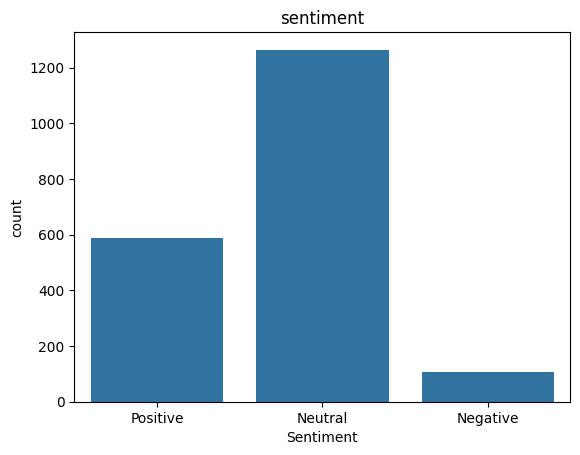

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x= df['Sentiment']).set_title('sentiment')

Based on the sentiment distribution chart, the number of negative emails is relatively low, yet it may still pose potential risks to workplace morale or organizational culture. On the other hand, the majority of emails show positive or neutral sentiments, indicating a generally healthy communication environment.
To better understand the causes of negative emails, the organization should consider conducting employee surveys, collecting feedback, or organizing training sessions on corporate culture. These actions can help foster a more positive and supportive work environment.

In [ ]:
nega_year = df.groupby('year')['Sentiment'].apply(lambda x: (x == 'Negative').sum())
nega_year

,Sentiment
year,
2010,53
2011,52


Text(0.5, 1.0, 'negative')

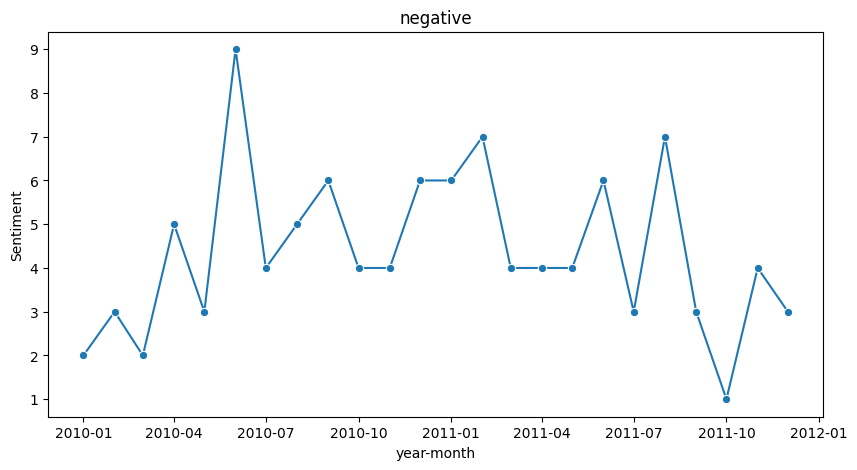

In [ ]:
# plot negative of month
df['year-month'] = df['date'].dt.to_period('M')
nega_month = df.groupby('year-month')['Sentiment'].apply(lambda x: (x == 'Negative').sum())
nega_m = pd.DataFrame(nega_month,columns=['Sentiment']).reset_index()
nega_m['year-month'] = nega_m['year-month'].dt.to_timestamp()

plt.figure(figsize=(10, 5))
sns.lineplot(data=nega_m, x='year-month', y='Sentiment', marker='o').set_title('negative')

The chart illustrating the monthly trend of negative emails reveals a significant increase starting from June 2010, which remained relatively high until around August 2011 before showing signs of decline.
This trend raises concerns about internal factors or events that may have impacted employee morale or satisfaction during that period — especially around mid-2010.
It is advisable for the organization to review what happened during that time frame to identify possible causes, learn from them, and implement appropriate HR strategies to minimize negativity and foster a healthier work environment.

#task 3

In [ ]:
# add column with score
score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['Score'] = df['Sentiment'].map(score_map)


In [ ]:
df.head()

,Subject,body,date,from,year,month,len_subject,len_body,Sentiment,Sentiment_TextBlob,year-month,Score
0,EnronOptions Update!,enronoptions announcement we have updated the ...,2010-05-10,sally beck,2010,5,20,605,Positive,Positive,2010-05,1
2,Phone Screen Interview - Shannon L. Burnham,when wednesday june am am gmt central time us ...,2011-07-25,sally beck,2011,7,44,65,Neutral,Neutral,2011-07,0
3,My new work email,we were thinking papasitos we can meet somewhe...,2010-03-25,johnny palmer,2010,3,18,121,Neutral,Negative,2010-03,0
4,Bet,since you never gave me the for the last time ...,2011-05-21,lydia delgado,2011,5,3,183,Neutral,Neutral,2011-05,0
5,Favor,sure just call me the bank that delivers we wi...,2011-10-23,eric bass,2011,10,6,102,Neutral,Positive,2011-10,0


In [ ]:
#group by Year-month and sum of score
monthly_scores = df.groupby(['from', 'year-month'])['Score'].sum().reset_index()
monthly_scores.rename(columns={'from': 'Employee', 'Score': 'Monthly_Score'}, inplace=True)


In [ ]:
monthly_scores

,Employee,year-month,Monthly_Score
0,bobette riner,2010-01,0
1,bobette riner,2010-02,3
2,bobette riner,2010-03,2
3,bobette riner,2010-04,1
4,bobette riner,2010-05,2
...,...,...,...
232,sally beck,2011-08,0
233,sally beck,2011-09,0
234,sally beck,2011-10,4
235,sally beck,2011-11,3


#task 4

In [ ]:
# get 3 employee have high score about negative
monthly_scores['year-month']= monthly_scores['year-month'].astype(str)
data= pd.DataFrame(columns=['Employee', 'year-month', 'Monthly_Score'])
for i in range(10,12):
    for j in range(1,13):
      if j < 10:
         l=monthly_scores[monthly_scores['year-month']==f'20{i}-0{j}']
         l=l.sort_values(by='Monthly_Score', ascending=False)[0:3]
         data = pd.concat([data,l], ignore_index=True)
      else:
         l=monthly_scores[monthly_scores['year-month']==f'20{i}-{j}']
         l=l.sort_values(by='Monthly_Score', ascending=False)[0:3]
         data = pd.concat([data,l], ignore_index=True)

In [ ]:
data

,Employee,year-month,Monthly_Score
0,kayne coulter,2010-01,5
1,patti thompson,2010-01,4
2,eric bass,2010-01,3
3,don baughman,2010-02,4
4,bobette riner,2010-02,3
...,...,...,...
67,bobette riner,2011-11,3
68,sally beck,2011-11,3
69,lydia delgado,2011-12,6
70,kayne coulter,2011-12,4


<Axes: xlabel='Employee', ylabel='Monthly_Score'>

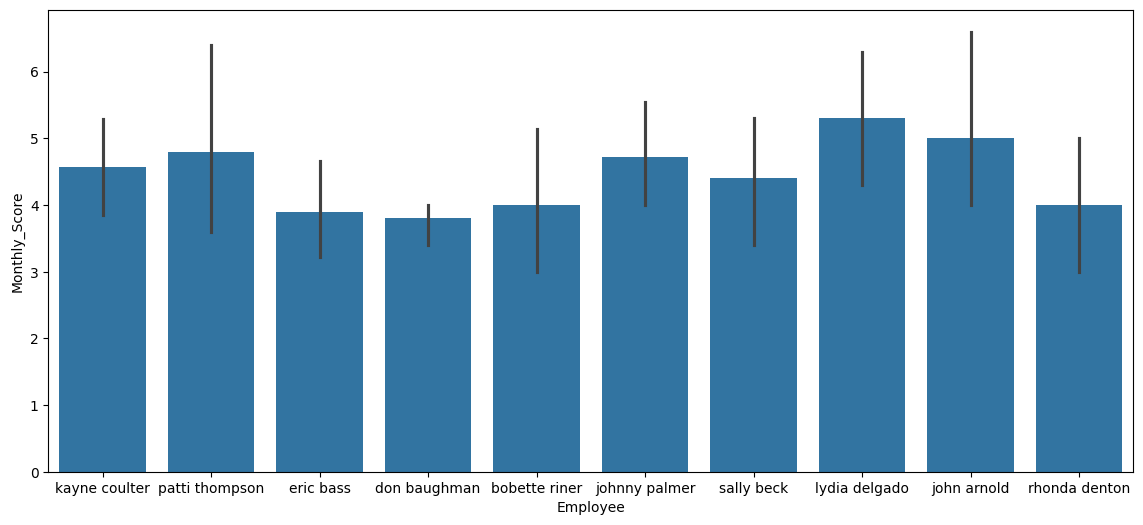

In [ ]:
# plot negative score of employee
plt.figure(figsize=(14, 6))
sns.barplot(data=data, x='Employee', y='Monthly_Score')

The chart represents the average monthly sentiment scores of employees, revealing clear differences in emotional tone across individuals. Lydia Delgado and John Arnold have the highest average sentiment scores, indicating generally positive communication in their emails. However, their high standard deviations suggest fluctuations in emotional tone over time.

In contrast, employees like Eric Bass, Don Baughman, and Rhonda Denton have lower sentiment scores, along with some degree of emotional variability. This may reflect potential stress, dissatisfaction, or misalignment within the workplace environment.

It is recommended that management monitor those with persistently low or unstable emotional scores, consider conducting employee surveys or one-on-one check-ins to identify the root causes, and provide targeted support to improve team morale and workplace wellbeing.



#task 5

In [ ]:
# get negative records
df_neg = df[df['Sentiment'] == 'Negative'].copy()

In [ ]:
#creat function to get employee can quit
def detect_flight_risk(df_neg, min_negatives=4, window_days=30):
    risk_employees = set()

    for employee, group in df_neg.groupby('from'):
        dates = pd.to_datetime(group['date']).sort_values().reset_index(drop=True)

        for i in range(len(dates) - min_negatives + 1):
            window_start = dates[i]
            window_end = window_start + pd.Timedelta(days=window_days)

            in_window = dates[(dates >= window_start) & (dates <= window_end)]

            if len(in_window) >= min_negatives:
                risk_employees.add(employee)
                break

    return list(risk_employees)


In [ ]:
flight_risk_employees = detect_flight_risk(df_neg)
flight_risk_df = pd.DataFrame({'Employee': flight_risk_employees})
flight_risk_df['Flight_Risk'] = True


In [ ]:
flight_risk_df


,Employee,Flight_Risk
0,sally beck,True
1,john arnold,True


#task 6

In [ ]:
#creat columns sum of word of body
df['word_count'] = df['body'].str.split().apply(len)

In [ ]:
#group year-month and employee to predict
monthly_features = df.groupby(['from', 'year-month']).agg(
    msg_count=('body', 'count'),
    avg_length=('len_body', 'mean'),
    avg_word_count=('word_count', 'mean'),
    Monthly_Score=('Score', 'sum')
).reset_index()
monthly_features

,from,year-month,msg_count,avg_length,avg_word_count,Monthly_Score
0,bobette riner,2010-01,2,101.000000,17.500000,0
1,bobette riner,2010-02,12,222.083333,37.416667,3
2,bobette riner,2010-03,11,241.545455,41.727273,2
3,bobette riner,2010-04,6,189.833333,30.166667,1
4,bobette riner,2010-05,3,210.000000,38.333333,2
...,...,...,...,...,...,...
232,sally beck,2011-08,12,271.416667,48.750000,0
233,sally beck,2011-09,1,245.000000,50.000000,0
234,sally beck,2011-10,5,198.000000,35.200000,4
235,sally beck,2011-11,5,330.200000,59.800000,3


In [ ]:
x= monthly_features[['msg_count', 'avg_length', 'avg_word_count']]
y =monthly_features['Monthly_Score']

In [ ]:
#split data
x_train, x_test, y_train,y_test= train_test_split(x,y, test_size=0.2, random_state= 42)

In [ ]:
#built pipeline and train
trains_fo = ColumnTransformer(transformers=[
('trainsfo',StandardScaler(),['msg_count', 'avg_length', 'avg_word_count'])
])
model = Pipeline(steps=[
    ('trainsfo',trains_fo),
    ('model', LinearRegression())
])
model.fit(x_train,y_train)

Pipeline(steps=[('trainsfo',
                 ColumnTransformer(transformers=[('trainsfo', StandardScaler(),
                                                  ['msg_count', 'avg_length',
                                                   'avg_word_count'])])),
                ('model', LinearRegression())])

#Features

msg_count (message count):
Represents the communication frequency of an employee. A higher number of messages may indicate increased engagement, which can be useful to detect emotional consistency or variation.

avg_length (average message length):
Longer emails may carry more emotional or informational content. This feature reflects the intensity or detail level in communication.


avg_word_count (average word count):
Indicates how expressive the message is. A higher word count may correspond with clearer emotional signals and richer language usage.

In [ ]:
results= model.predict(x_test)
print(r2_score(y_test,results))
print(mean_squared_error(y_test,results))
print(mean_absolute_error(y_test,results))

0.4040492686159304
2.445622467550511
1.1978693728215213


/tmp/ipython-input-96-4002178484.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results, hist=False).set_title('performance');
/tmp/ipython-input-96-4002178484.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=False);


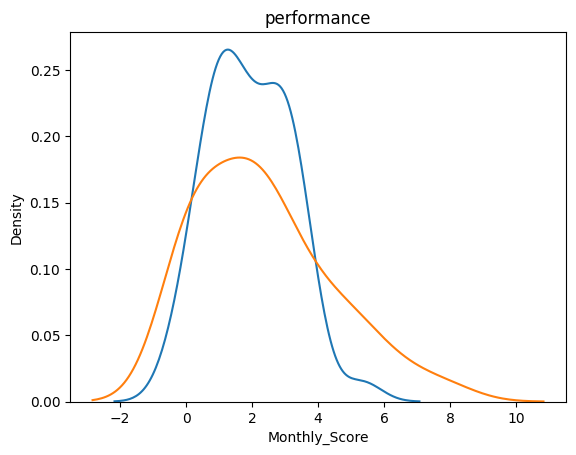

In [ ]:
fig, ax = plt.subplots();
sns.distplot(results, hist=False).set_title('performance');
sns.distplot(y_test, hist=False);

Through this project, I learned how to apply modern AI tools—particularly HuggingFace transformer models—for sentiment analysis in text data. Compared to traditional tools like TextBlob, transformer-based models provide much deeper contextual understanding, which is especially valuable in interpreting email content with nuanced expressions.

After evaluating both models, I place more trust in the results generated by the HuggingFace model (cardiffnlp/twitter-roberta-base-sentiment) due to its superior contextual awareness and better alignment with human-level sentiment interpretation.

That said, there are limitations: AI-generated results still require manual verification, and should not be treated as unquestionable outputs. AI performance can also be affected by noisy or inconsistent input data. Therefore, human judgment remains essential to guide, interpret, and validate the analysis effectively.

During the project, I realized that predicting sentiment scores based on the current input features is not truly feasible under the current conditions. The main reasons include:

Limited dataset size, which is insufficient for training and evaluating the model reliably.

Too few features, making it difficult for the model to capture meaningful patterns related to sentiment.

Low label quality, since the labels were generated using an LLM instead of being manually annotated.

If this were part of an official company project, I would strongly recommend a greater investment in data quality and labeling, especially with clearly verified sentiment tags. This would enable the development of a more reliable and business-relevant predictive model.